## Bounce Drops Dataset

In [1]:
import os, fnmatch, csv
import numpy as np

class Experiment(object):
    def __init__(self, data, name, start=0, end=-1, volume=1, surfaceV=1000, frame_rate=29.95, \
                 outlier=False, threeD=False, charge=1E-11, u0=1, double=False):
        self.data = data
        self.name = name
        self.start = start
        self.end = end
        self.volume = volume
        self.surfaceV = surfaceV
        self.frame_rate = frame_rate
        self.outlier = outlier
        self.threeD = threeD
        self.charge = charge
        self.u0 = u0
        self.double = double

def import_data(exp_class):
    """
    Takes an experiment type and returns an array of Experiment class objects, with attributes specified by
    a metadata csv. The 'data' attribute The column heads include:
    'R','Area','XM','YM','Major','Minor','Angle','Circ','Slice','AR','Round','Solidity'
    """
    meta_file_location = '../data/' + exp_class + '/meta2.csv'
    imported_datatype = ('U9', int, int, float, float, float, bool, bool)
    metadata = np.genfromtxt(meta_file_location, delimiter=',', dtype=imported_datatype, names=True)
    globals()[exp_class + '_data_list'] = np.array([])
    for drop in metadata:
        if drop['double']==True:
            name = 'drop' + str(drop['name'])
            path = '../data/' + exp_class + '/' + str(drop['name'][:-2:]) + '.csv'
            print(path)
            data = np.genfromtxt(path, dtype=float, delimiter=',', names=True)
            if name[-1::]=='1':
                data = data[0::2]
            else:
                data = data[1::2]
        else:
            name = 'drop' + str(drop['name'])
            path = '../data/' + exp_class + '/' + str(drop['name']) + '.csv'
            data = np.genfromtxt(path, dtype=float, delimiter=',', names=True)      
        start = drop['start']
        end = drop['end']
        volume = drop['volume']
        surfaceV = drop['surfaceV']
        frame_rate = drop['frame_rate']
        outlier = drop['outlier']
        double = drop['double']
        # check for gaps
        if (data.shape[0]) < data['Slice'][-1]:
            print('there is {} cells of gap'.format((data['Slice'][-1] - data.shape[0])))
        globals()[str(name)] = Experiment(data, name, start, end, volume, surfaceV, \
                                                           frame_rate, outlier, double)
        globals()[exp_class + '_data_list'] = np.append(globals()[exp_class + '_data_list'], \
                                                        globals()[str(name)])

In [2]:
exp_class = 'dielectric'
import_data(exp_class)

# use fancy indexing to make a list of outliers
mask = [datas.outlier==False for datas in dielectric_data_list]
outliers = {datas.name:datas for datas in dielectric_data_list[mask]}
#broken_mask = [datas.name!='drop05714' for datas in dielectric_data_list]
alldrops = {datas.name:datas for datas in dielectric_data_list}

../data/dielectric/07131.csv
../data/dielectric/07131.csv
../data/dielectric/07132.csv
../data/dielectric/07132.csv
../data/dielectric/07133.csv
../data/dielectric/07133.csv


## Filtering

In [3]:
from scipy import signal
def sg_filter(y, dt):
    try:
        if y.shape[0]>25:
            window = 25
        else:
            window = y.shape[0]
            if window % 2 ==0:
                window-=3
        return derivs(y,window,dt)
    except ValueError:
        print(window)
        
def derivs(y,window,dt):
    dtdt=dt*dt
    y_savgol = signal.savgol_filter(y, window, 3, deriv=0, axis=0)
    y_savgol1 = signal.savgol_filter(y_savgol, window, 3, deriv=0, axis=0)
    y_savgol2 = signal.savgol_filter(y_savgol1, window, 3, deriv=0, axis=0)
    y_savgol3 = signal.savgol_filter(y_savgol2, window, 3, deriv=0, axis=0)
    dy_savgol = signal.savgol_filter(y_savgol3, window, 3, deriv=1, axis=0)/dt
    ddy_savgol = signal.savgol_filter(y_savgol3, window, 3, deriv=2, axis=0)/dtdt
    return y_savgol3, dy_savgol, ddy_savgol

##  Trajectory Plots

In [4]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
%config InlineBackend.figure_formats=['svg']
%matplotlib inline

def trajectory(dataset, component='XM'):
    tracking = dataset.data
    a = dataset.start
    b = dataset.end
    if component in dataset.data.dtype.names:
        trackdir = component
    else:
        print("Only valid arguments are 'x' and 'y'")
        raise
    try:
        t = tracking['Slice'][a:-b]/dataset.frame_rate
        if trackdir == 'YM':
            x_zeroed = tracking['YM']
            #x_zeroed = tracking['YM']-(tracking['YM'][0]-tracking['Minor'][0]/2)
            x_points = x_zeroed[a:-b]
            x = sg_filter(x_points, t[1]-t[0])[0]
        else:
            x_points = tracking[trackdir][a:-b]
            x = sg_filter(tracking[trackdir][a:-b],t[1]-t[0])[0]
        dx = sg_filter(tracking[trackdir][a:-b],t[1]-t[0])[1]
        ddx = sg_filter(tracking[trackdir][a:-b],t[1]-t[0])[2]
        derivs=[x,dx,ddx]
        return t, derivs, x_points
    except TypeError:
        print(dataset.name)

def plotter(dataset, raw=False, deriv=1, component='XM'):
    (t, derivs, x_points) = trajectory(dataset, component)
    if raw==True:
        plt.plot(t,x_points, label=dataset.name)
    else:
        plt.plot(t,derivs[deriv], label=dataset.name)
    

In [5]:
def plot_series(expgroup, raw=False, deriv=1, component='XM'):
    if raw==True and deriv !=0:
        raw = False
    for keys, vals in expgroup.items():
        plotter(vals, raw, deriv, component)
    #plt.ylim((-2,2))
    plt.xlim((0.1,2))
    plt.xlabel('t ($s$)')
    #plt.ylim((-1,.3))
    plt.ylabel(component)
    plt.legend(loc = 'best')
    plt.show()

In [6]:
#subset = {'drop07135':drop07135, 'drop07136':drop07136}

##  Munging

In [65]:
def radius(volume):
    return (3 * volume * 1E-6/(np.pi * 4))**(1/3.)

def weber(data, ym, dt):
    surface_tension = 72.86/1000
    density = 1000
    return density*(2*np.mean(ellipse(data))/100)*(sg_filter(ym, dt)[1]/100)**2/surface_tension

In [66]:
from scipy.signal import argrelextrema
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import traceback

def ellipse(data):
    YM = data['YM']
    a = data['Major']/2
    b = data['Minor']/2
    Angle = (data['Angle']-90)*np.pi/180
    return a*b/((b*np.cos(Angle))**2 + (a*np.sin(Angle))**2)**(1/2)

def ym_0(data, n):
    ym = data.data['YM'][data.start:-data.end]
    minm = argrelextrema(ym, np.less, order=4)[0][::]
    maxm = argrelextrema(ym, np.greater, order=1)[0][::]
    minm = np.append([0],minm)
    minm = np.append(minm, [len(ym)-1])
    intstart = minm[n]
    intend = minm[n+1]
    if minm.shape[0] == 2:
        YM_0 = 0
    else:
        YM_0 = ym[minm[1]] - ellipse(k.data)[minm[1]]
    return YM_0, intstart, intend, minm

def partition(n):
    pass
    
def munge_plot(k, n=0, order=2, whole_drop=False):
    a = k.start
    b = -k.end
    t = k.data['Slice'][a:b]/k.frame_rate
    ym = k.data['YM'][a:b]
    circ = k.data['Circ'][a:b]
    dt = t[1]-t[0]    
    host = host_subplot(111, axes_class=AA.Axes)
    plt.subplots_adjust(right=0.75)
    try:
        YM_0, intstart, intend, minm = ym_0(k, n)
        ym = ym - YM_0
        # Note that YM_0 needs an absolute reference critera for drops with no bounces
        contact = ym - ellipse(k.data[a:b]) # distance from the bottom of the drop to YM_0
        atol = np.std(ellipse(k.data[a:b]))*5
        above_mask = np.invert(np.isclose(contact, 0, atol=atol))
        below_zero_mask = np.invert(np.array([(contact <= 0)]))
        contact_mask = np.logical_and(above_mask, below_zero_mask).flatten()
        intendmask = np.array([(t <= t[intend])])
        intstartmask = np.array([(t >= t[intstart])])
        parted_mask = np.logical_and.reduce((intstartmask.flatten(), intendmask.flatten(), contact_mask))
        #maxm = argrelextrema(sg_filter(ym[parted_mask],dt)[0], np.greater, order=4)[0][::]
        host.plot(t[contact_mask], ym[contact_mask], 'b.')
        host.plot(t[intstart:intend],ellipse(k.data[a:b])[intstart:intend])
    except IndexError:
        print(traceback.format_exc())
        intstart = 0
        intend = -1
        #intendmask = np.array([(t < t[intend])])
        parted_mask = (np.ones(t.shape, dtype=bool))
    
    ax2 = host.twinx()
    ax3 = host.twinx()
    host.plot(t,ym,'k-', label='Pos')
    host.plot(t[minm], ym[minm], 'go', label='minima')
    host.plot(t[parted_mask],sg_filter(ym[parted_mask], dt)[0],'r', label='Pos filtered')
    host.plot(t[parted_mask], weber(k.data[parted_mask], ym[parted_mask], dt), label='Weber')
    #host.plot(t[parted_mask][maxm], ym[parted_mask][maxm], 'co', label='maxima')
    host.set_ylabel('YM $cm$')
    ax2.plot(t, sg_filter(circ,dt)[0], '-', label='Circ')
    ax2.set_ylabel('Circularity')
    ax3.plot(t[parted_mask], sg_filter(ym[parted_mask], dt)[2], 'g', label='Accel')
    ax3.set_ylabel('Accel $cm/s^2$')
    host.set_xlabel('t (s)')
    if whole_drop==True:
        #print(radius(k.volume)*100, np.mean(ellipse(k.data[a:b])))
        interval = [t[0],t[-1]]
    else:
        interval = [t[intstart],t[intend]]
        #interval = [t_sec[0],t_sec[-1]]
    host.set_xlim(interval)

    offset = 60
    new_fixed_axis = ax3.get_grid_helper().new_fixed_axis
    ax3.axis["right"] = new_fixed_axis(loc="right",
                                        axes=ax3,
                                        offset=(offset, 0))

    ax3.axis["right"].toggle(all=True)
    host.legend(title=k.name)
    plt.show()
    if whole_drop==False:
        print("Impact Weber number = {:.3f}".format(weber(k.data[parted_mask], ym[parted_mask], dt)[-1]))
        #points = np.array([t, y]).T.reshape(-1, 1, 2)
        #segments = np.concatenate([points[:-1], points[1:]], axis=1)
        plt.plot(sg_filter(ym[parted_mask], dt)[0], sg_filter(ym[parted_mask], dt)[2])
        plt.xlabel('YM $cm$')
        plt.ylabel('Accel $cm/s^2$')
        plt.show()

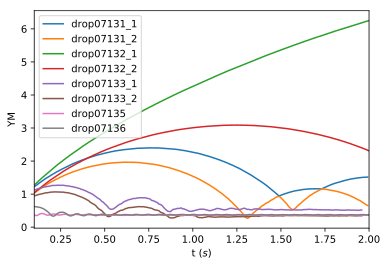

In [67]:
plot_series(alldrops, deriv=0, component='YM', raw=True)

/home/erin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:68: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 240 but corresponding boolean dimension is 234


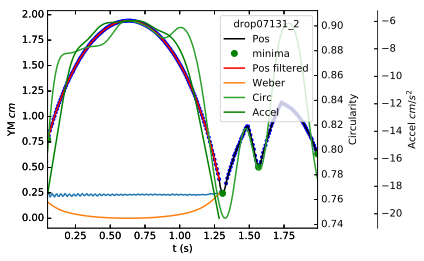

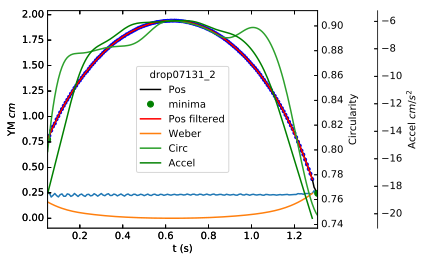

/home/erin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:94: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 240 but corresponding boolean dimension is 234


Impact Weber number = 0.244


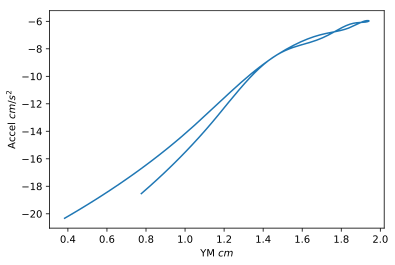

In [68]:
k = drop07131_2
n_part = 0
order = 4

munge_plot(k, order=order, n=n_part, whole_drop=True)
munge_plot(k, order=order, n=n_part, whole_drop=False)

In [11]:
#header = {'name':1,'start':2,'end':3,'volume':4,'surfaceV':5,'frame_rate':6,'outlier':7, 'double':8}
#row = !grep -n "{k.name[4:]}" ../data/dielectric/meta2.csv | cut -d , -f 1 | cut -d : -f 1
#row = int(row[0])
#col = header['start']
#value = 1

In [12]:
%%bash -s "$row" "$col" "$value"
#awk -v r=$1 -v c=$2 -v val=$3 -F, 'BEGIN{OFS=","}; NR != r; NR == r {$c = val; print}' \
#../data/dielectric/meta2.csv > ../data/dielectric/meta3.csv
#cp ../data/dielectric/meta3.csv ../data/dielectric/meta2.csv
#rm ../data/dielectric/meta3.csv
cat ../data/dielectric/meta2.csv

name,start,end,volume,surfaceV,frame_rate,outlier,double
07131_1,5,1,0.092,310,120,True,True
07131_2,5,1,0.092,246.7,120,True,True
07132_1,0,1,0.0654,266.7,120,False,True
07132_2,5,1,0.0654,263.3,120,False,True
07133_1,0,1,0.0287,243.3,120,False,True
07133_2,0,1,0.0287,230.0,120,False,True
07135,1,1,0.04,396.7,120,False,False
07136,0,1,0.05,307.5,120,False,False


# Bouncing simulation
The equation of motion is given by 
$$m\frac{d^2y}{dt^2} = F_{EP} + F_{img} + F_{DEP} + F_{d}$$

where
$$f_{EP} = qE$$ and $$f_{DEP} = 2 \pi  R_{drop}^3 \epsilon_{air}  K  \epsilon_0  \nabla |E|^2$$

In this geometry

$$E = 2 \pi k \sigma \left(1 - \frac{z}{\sqrt{z^2 + R^2}}\right)$$
and
$$\nabla |E|^2 = 2 (2 \pi k \sigma)^2 R^2 \frac{z - \sqrt{R^2 + z^2}}{(R^2 + z^2)^2} $$


In [55]:
#inputs
"""I need to get these parameters from the drop metadata"""
V = 300
d = 2.54/100
sigma=145*1.1/3*5.5E-8      # charge density
R = 2.54/200           # surface radius [m] 
q = 6*2.3*2E-11 *1.2      # droplet net charge [C]
volume = 0.06 #0.065  # droplet volume [mL]
u0 = (15.3-1)/100          # droplet initial velocity [m/s]
puddleness = 3/2
m = 1000 * volume * 1E-6                          #droplet mass [kg]
R_drop = (3 * volume * 1E-6/(np.pi * 4))**(1/3.)  #droplet radius [m]
z0 = R_drop/puddleness

#physical constants
eta_0 = 8.85E-12       # vacuum permitivity 
k = 1/(4*np.pi*eta_0)  # Coulomb's constant
global k, eta_0

print('drop radius {:.2f} cm'.format(R_drop*100))
#print(np.sqrt(q*R*sigma/eta_0))
print('surface potential {:.2} '.format(V*eta_0/d))
print('surface charge density {:.2} C/m^2'.format(sigma))
print(q)

drop radius 0.24 cm
surface potential 1e-07 
surface charge density 2.9e-06 C/m^2
3.3119999999999995e-10


Simulated fieldmeter reading 0.50 kV
Simulated fieldmeter reading 17.44 kV/m


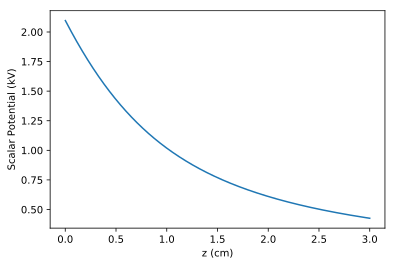

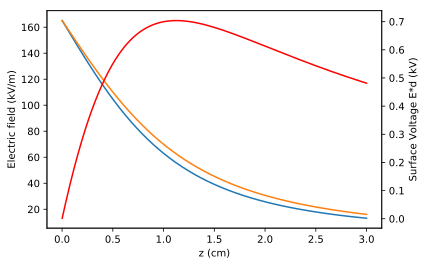

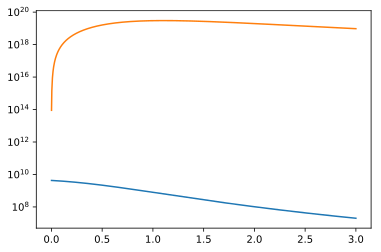

In [56]:
def electric_field(z, R=R, sigma=sigma):
    E = k * sigma * 2 * np.pi * (1 - z/np.sqrt(z**2. + R**2.))
    #E = 664/(2.54/100)
    del_E2 = 2 * (k * sigma * 2 * np.pi)**2. * R**2. * (z - np.sqrt(R**2. + z**2.))/(R**2. + z**2.)**2.
    V = k * sigma * 2 * np.pi * (np.sqrt(z**2. + R**2.) - z)
    E_sqr = 4*k*sigma*np.arctan(d**2/(2*z*np.sqrt(2*d**2 + 4*z**2)))
    del_E_sqr2 = 32* k**2 *((-2* d**2)/(2 *d**2 + 4 *z**2)**(3/2) - d**2/(2 *z**2 *np.sqrt(2 *d**2 + 4* z**2))\
                            *sigma**2 *np.arctan(d**2/(2 *z *np.sqrt(2* d**2 + 4* z**2))))\
    /(1 + d**4/(4* z**2 *(2 *d**2 + 4 *z**2)))
    return E, del_E2, V, E_sqr, del_E_sqr2

print('Simulated fieldmeter reading {:.2f} kV'.format(electric_field(2.54/100)[2]/1000))
print('Simulated fieldmeter reading {:.2f} kV/m'.format(electric_field(2.54/100)[0]/1000))

# Plot the results
from matplotlib import rc
import pylab
%config InlineBackend.figure_formats=['svg']
%matplotlib inline
#rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
#rc('text', usetex=True)

zz = np.linspace(0.00001, 3./100, 1000)              
#zz = np.linspace(0, 4, 1000)
plt.plot(zz*100, electric_field(zz)[2]/1000)
plt.xlabel('z (cm)')
plt.ylabel('Scalar Potential (kV)')
plt.show()

fig, ax1 = plt.subplots()
ax1.plot(zz*100, electric_field(zz)[0]/1000, zz*100, electric_field(zz)[3]/1000)
ax2 = ax1.twinx()
ax2.plot(zz*100, np.multiply(electric_field(zz)[3],zz)/1000, 'r')
ax1.set_xlabel('z (cm)')
ax1.set_ylabel('Electric field (kV/m)')
ax2.set_ylabel('Surface Voltage E*d (kV)')
plt.show()

plt.semilogy(zz*100, np.abs(electric_field(zz)[1]/1000), zz*100, np.abs(electric_field(zz)[4]/1000))
plt.show()

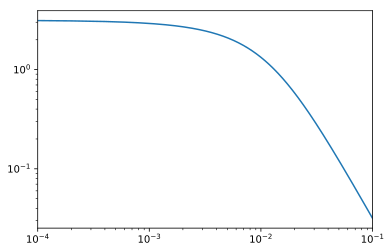

In [57]:
z = np.linspace(0.0001,10/100,1000)
a = d
k = 1/(4*np.pi*eta_0)
def E(z):
    return 4*k*sigma*np.arctan(a**2/(2*z*(2*a**2 + 4*z**2)**(1/2)))

#k, sigma, a, z, = symbols('k, sigma, a, z')
#pprint(4*k*sigma*atan(a**2/(2*z*(2*a**2 + 4*z**2)**(1/2))))
%matplotlib inline
plt.figure
plt.loglog(z, E(z)/(sigma/(2*np.pi*eta_0)))
#plt.autoscale(enable=True, axis='y', tight=True)
plt.autoscale(enable=True, axis='x', tight=True)
plt.show()


In [58]:
def force_ep(z, q=q):
    eta_a=3
    im = -1/(16*np.pi*1*eta_0)*(1-eta_a)/(1+eta_a)*q**2/z**2
    return q * electric_field(z)[3]

def force_dep(z, R_drop=R_drop):
    eta_air = 1.
    eta_water = 90.
    K = (eta_water - eta_air)/(eta_water + 2 * eta_air)
    #return -2 * np.pi * R_drop**3. * eta_air * K * eta_0 * electric_field(z)[4]
    return 0
    
def reynolds(v, R_drop=R_drop):
    nu = 15.11E-6
    D = R_drop * 2
    return D*np.abs(v)/nu

def drag(v, R_drop=R_drop):
    rho = 1.225
    Cd = 24/reynolds(v) + 5/np.sqrt(reynolds(v)) + 0.3
    return Cd*2*rho*np.pi*R_drop**2*v**2
    
print('DEP {}'.format(force_dep(R_drop/3)))
print('EP {}'.format(force_ep(R_drop/3)))

DEP 0
EP 5.1581811888498745e-05


In [59]:
# model data
def exp_data(x):
    v = -11.281*x**5 + 66.22*x**4 - 145.47*x**3 + 148.49*x**2 - 70.216*x + 15.301
    a = -11.281*5*x**4 + 66.22*4*x**3 - 145.47*3*x**2 + 148.49*2*x - 70.216
    y = 15.301*x - 35.108*x**2 + 49.4967*x**3 - 36.3675*x**4 + 13.244 *x**5 - 1.88017* x**6
    return v, a, y

In [60]:
"""x = np.array([R_drop/puddleness]).tolist()
v = [u0]
t = [0]
EP = [force_ep(x[0])]
DEP = [force_dep(x[0])]
a = [(-EP[0] - DEP[0])/m]
re = [reynolds(v[0])]
drg = [drag(v[0])]

dt = 0.00001
    
while x[-1] >= R_drop/puddleness and t[-1] <= 1.6:
    a.append((-EP[-1] - DEP[-1] - drg[-1])/m)
    v.append(a[-1]*dt + v[-1])
    x.append(v[-1]*dt + x[-1])
    EP.append(force_ep(x[-1]))
    DEP.append(force_dep(x[-1]))
    re.append(reynolds(v[-1]))
    drg.append(drag(v[-1]))
    t.append(t[-1] + dt)

EP  = np.array(EP)
DEP = np.array(DEP)
a   = np.array(a)
v   = np.array(v)
x   = np.array(x)
t   = np.array(t)
re  = np.array(re)

# plotting
pylab.rcParams['figure.figsize'] = (8.0, 15.0)
f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(8, sharex=True)
ax1.plot(t, v*100, t, exp_data(t)[0])
ax1.set_ylabel("Velocity (cm/s)")
ax2.plot(t, x*100, t, exp_data(t)[2])
ax2.set_ylabel("Position (cm)")
ax3.plot(t, a*100, t, exp_data(t)[1])
ax3.set_ylabel("Acceleration (cm/s^2)")
ax6.plot(t, EP/DEP)
ax6.set_ylabel("Force ratio")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax4.plot(t, DEP)
ax4.set_ylabel("Dielectrophoresis force (N)")
ax5.plot(t, EP)
ax5.set_ylabel("Electrophoresis force (N)")
ax7.plot(t, re)
ax8.plot(t, drg)
ax6.set_xlabel("t (s)")
f.tight_layout()
plt.show()""";

In [61]:
#plt.figure(figsize=(9,5))
#plt.plot(x*100, a*100, x*100, exp_data(t)[1])
#plt.show

In [62]:
import scipy.integrate as int

def f(y, t, params):
    z, u = y      # unpack current values of y
    m, R_drop, sigma, q = params # unpack parameters   
    derivs = [u, (-force_dep(z) - force_ep(z) - drag(u))/m] # list of dy/dt=f functions
    return derivs

# Initial values
z0 = z0    # initial displacement
u0 = u0     # initial velocity

# Bundle parameters for ODE solver
params = [m, R_drop, sigma, q]

# Bundle initial conditions for ODE solver
y0 = [z0, u0]

# Make time array for solution
tStop = 2.2
tInc = 0.0005
t_rk = np.arange(0., tStop, tInc)

# Call the ODE solver
psoln = int.odeint(f, y0, t_rk, args=(params,))

[ 0.00161906  0.00169046  0.00176165 ...,  0.03866469  0.03864781
  0.03863092]


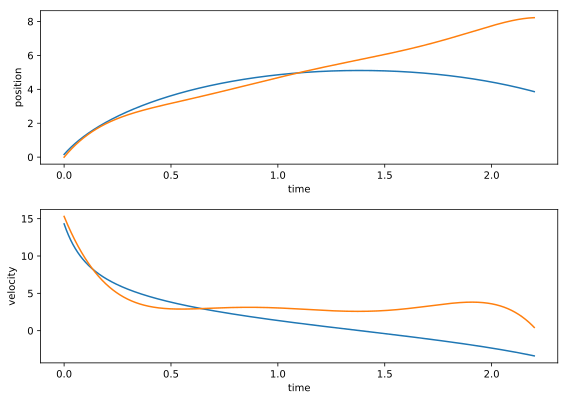

In [63]:
ODE_mask = ([psoln[:,0]>=0])
print(psoln[:,0][ODE_mask])
# Plot results
fig = plt.figure(1, figsize=(8,8))

# Plot theta as a function of time
ax1 = fig.add_subplot(311)
ax1.plot(t_rk[ODE_mask], psoln[:,0][ODE_mask]*100, t_rk, exp_data(t_rk)[2])
#ax1.plot(t_rk[ODE_mask], psoln[ODE_mask]*100)
ax1.set_xlabel('time')
ax1.set_ylabel('position')

# Plot omega as a function of time
ax2 = fig.add_subplot(312)
ax2.plot(t_rk[ODE_mask], psoln[:,1][ODE_mask]*100, t_rk, exp_data(t_rk)[0])
ax2.set_xlabel('time')
ax2.set_ylabel('velocity')

plt.tight_layout()
plt.show()

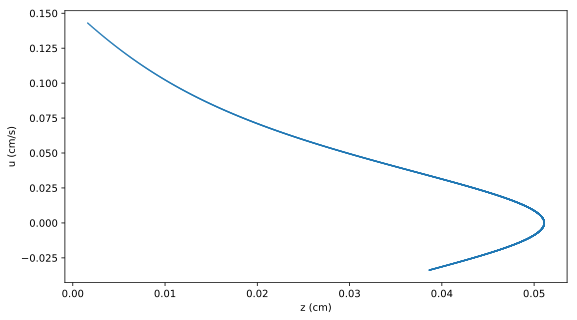

In [64]:
# Plot omega vs theta
plt.figure(figsize=(9,5))
plt.plot(psoln[:,0], psoln[:,1], '.', ms=1)
plt.xlabel('z (cm)')
plt.ylabel('u (cm/s)')
plt.show()

Need to get acceleration from psoln, make notes about integrator, methods...

In [23]:
#from sympy import *
#init_printing()
#
#y, z, nu, a = symbols('y z nu a')
#nu*integrate(z/((z**2 + y**2)*sqrt(z**2 + y**2 + a**2/4)), (y,0,a/2))

Perhaps I need a substution of some kind.